#### 453.A2 - Clustering and Classification

In [9]:
import pandas as pd
import numpy as np
import re
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Wrangling
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Preprocessing
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import gensim
from gensim import corpora
from sklearn.decomposition import TruncatedSVD

# Model Diagnostics
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
pd.set_option('display.max_colwidth',None)

#### Import Data

In [10]:
data = pd.read_csv('/Users/dylanhayashi/Desktop/Northwestern/MSDS_453_Public/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv')

In [11]:
data = data.rename(columns={
    'Genre of Movie':'Genre',
    'Review Type (pos or neg)':'Sentiment',
    'Movie Title':'Title',
    'Text':'Unprocessed Text'
})

#### Data Wrangling, Preprocessing

In [12]:
# Data Wrangling

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def nlp_transformations(df):
    """
    Apply NLP transformations to a pandas DataFrame.
    Parameters: df (DataFrame): Input dataframe with a column named 'Text'.
    Returns: DataFrame: A new dataframe with added columns for each NLP transformation.
    """
    df['Tokens'] = df['Unprocessed Text'].apply(word_tokenize)
    df['Normalized'] = df['Tokens'].apply(lambda x: [word.lower() for word in x])
    df['Lemmatized'] = df['Normalized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    df['No_Stop_Words'] = df['Lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
    df['Cleaned'] = df['No_Stop_Words'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', word) for word in x])
    df['Cleaned'] = df['Cleaned'].apply(lambda x: [word for word in x if word != ''])
    df['wrangle_one'] = df['Normalized']
    df['wrangle_two'] = df['No_Stop_Words']
    df['Text'] = df['Cleaned']
    return df

wrangled_data = nlp_transformations(data).sort_values(['Genre','Title','Sentiment'])
wrangled_data.head()

,Doc_ID,DSI_Title,Unprocessed Text,Submission File Name,Student Name,Genre,Sentiment,Title,Tokens,Normalized,Lemmatized,No_Stop_Words,Cleaned,wrangle_one,wrangle_two,Text
110,40,KCM_Doc1_AngelHasFallen,Boredom sets in long before the start of Angel...,KCM_Doc1_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[Boredom, sets, in, long, before, the, start, ...","[boredom, sets, in, long, before, the, start, ...","[boredom, set, in, long, before, the, start, o...","[boredom, set, long, start, angel, ha, fallen,...","[boredom, set, long, start, angel, ha, fallen,...","[boredom, sets, in, long, before, the, start, ...","[boredom, set, long, start, angel, ha, fallen,...","[boredom, set, long, start, angel, ha, fallen,..."
111,41,KCM_Doc2_AngelHasFallen,\nWho ARE all these people?\n\nThat was what...,KCM_Doc2_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[Who, ARE, all, these, people, ?, , That, wa...","[who, are, all, these, people, ?, , that, wa...","[who, are, all, these, people, ?, , that, wa...","[who, people, ?, , wa, muttered, entered, fi...","[who, people, wa, muttered, entered, first, sc...","[who, are, all, these, people, ?, , that, wa...","[who, people, ?, , wa, muttered, entered, fi...","[who, people, wa, muttered, entered, first, sc..."
112,42,KCM_Doc3_AngelHasFallen,Ric Roman Waughs Angel Has Fallen sees U.S. S...,KCM_Doc3_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[Ric, Roman, Waughs, Angel, Has, Fallen, sees...","[ric, roman, waughs, angel, has, fallen, sees...","[ric, roman, waughs, angel, ha, fallen, see, ...","[ric, roman, waughs, angel, ha, fallen, see, ...","[ric, roman, waughs, angel, ha, fallen, see, u...","[ric, roman, waughs, angel, has, fallen, sees...","[ric, roman, waughs, angel, ha, fallen, see, ...","[ric, roman, waughs, angel, ha, fallen, see, u..."
113,43,KCM_Doc4_AngelHasFallen,There is a certain mindless pleasure in the Fa...,KCM_Doc4_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[There, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w..."
114,44,KCM_Doc5_AngelHasFallen,"No, you dont need to have seen Olympus Has F...",KCM_Doc5_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[No, ,, you, dont, need, to, have, seen, Oly...","[no, ,, you, dont, need, to, have, seen, oly...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,..."


In [13]:
# List of markers to use in the plot
markers = {'Action': 'o', 'Horror': 's', 'Sci-Fi': 'D', 'Comedy': '^'}
colors = plt.cm.jet(np.linspace(0, 1, len(wrangled_data['Title'].unique())))

In [14]:
# tf-idf Vectorization
vectorizer = TfidfVectorizer()  # Consider limiting features
tf_idf_matrix = vectorizer.fit_transform(wrangled_data['Text'].apply(' '.join))

In [15]:
# Doc2Vec Vectorization
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(wrangled_data['Text'])]
model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
wrangled_data['doc2vec_vectors'] = wrangled_data['Text'].apply(lambda x: model.infer_vector(x))

#### Part 1 - Clustering

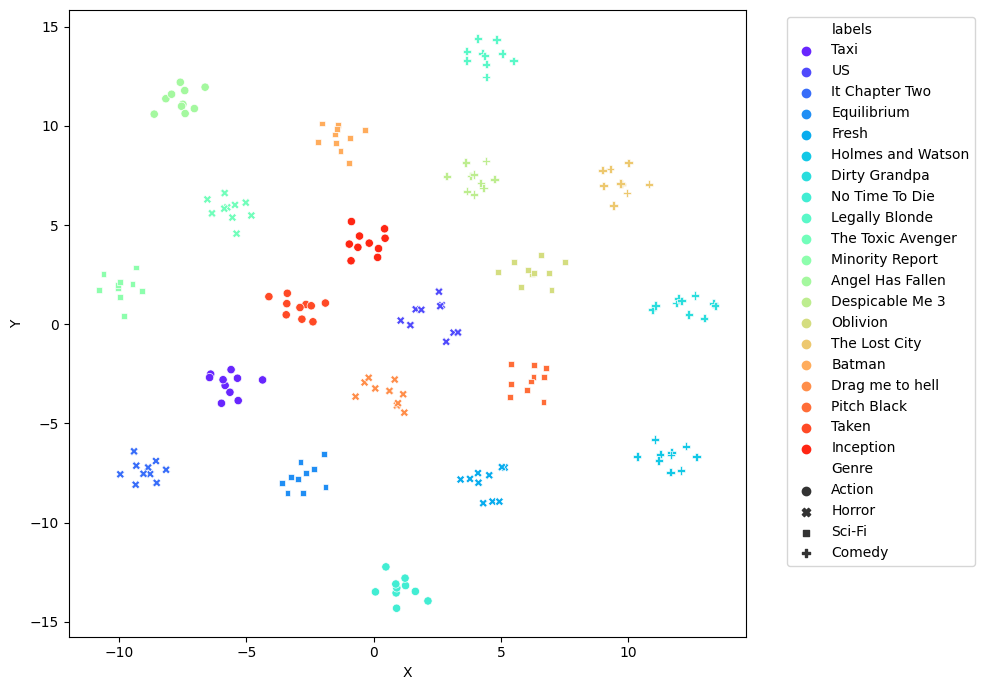

For n_clusters = 20, the average silhouette_score is : 0.11329478220415914


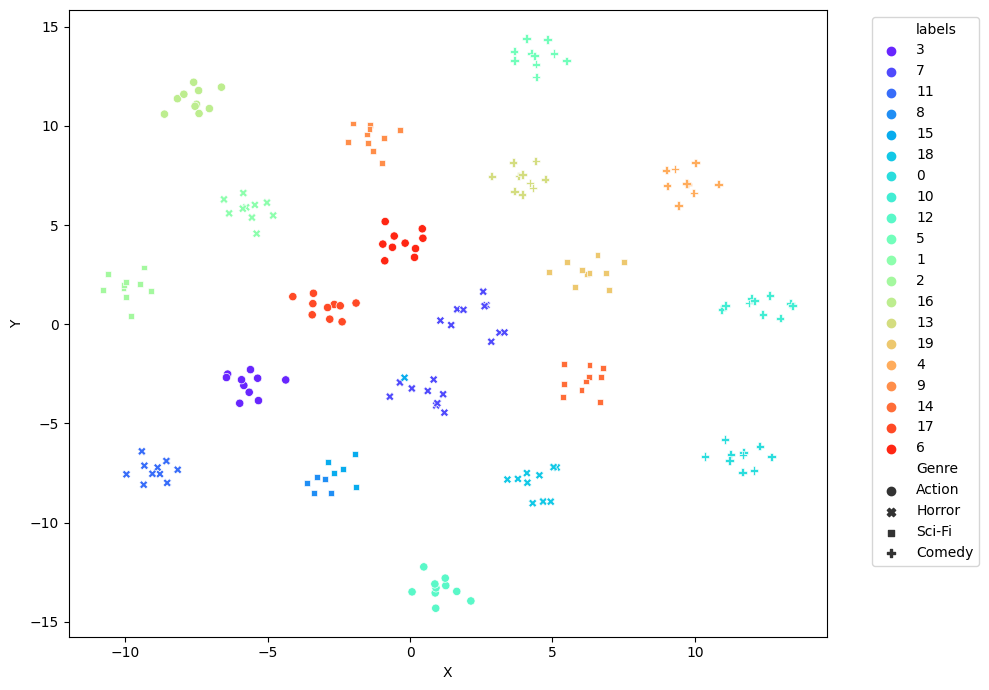

For n_clusters = 4, the average silhouette_score is : 0.025413992909867532


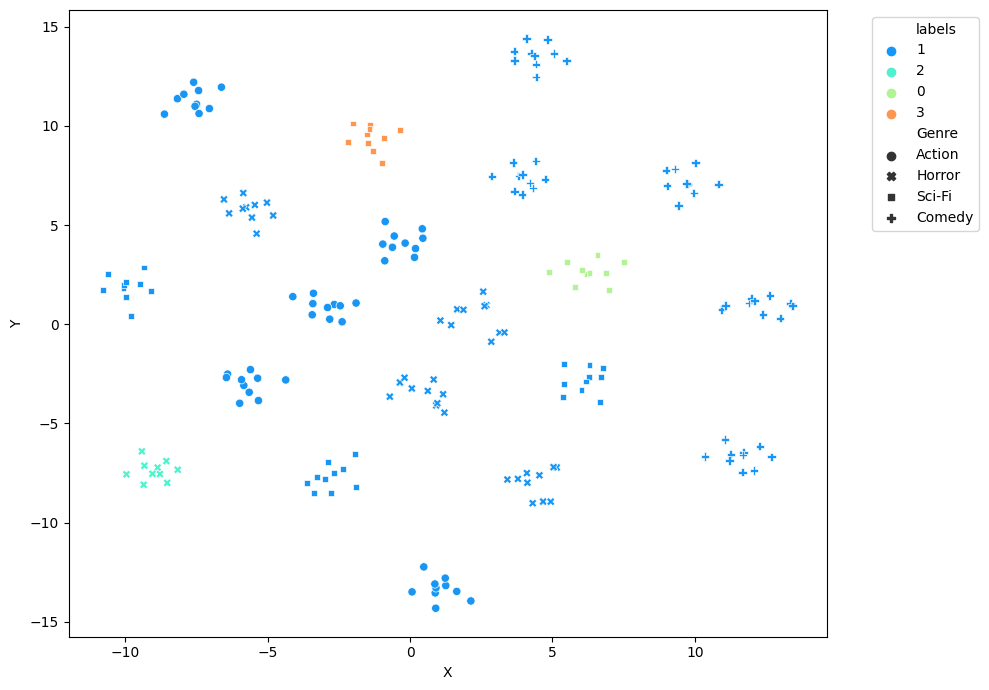

,Cluster,Movies,Genres
0,1,[Oblivion],[Sci-Fi]
1,2,"[Equilibrium, The Lost City, Despicable Me 3, Angel Has Fallen, Holmes and Watson, The Toxic Avenger, Inception, Dirty Grandpa, Taken, Fresh, Taxi, US, No Time To Die, Legally Blonde, Pitch Black, Drag me to hell, Minority Report]","[Horror, Sci-Fi, Action, Comedy]"
2,3,[It Chapter Two],[Horror]
3,4,[Batman],[Sci-Fi]


In [39]:
# Create t-sne 
model_tsne = TSNE(n_components=2, init='random')
transformed_values = model_tsne.fit_transform(tf_idf_matrix)
tsne_df = pd.DataFrame(transformed_values, columns=['X', 'Y'])
tsne_df['Genre'] = wrangled_data['Genre']  
k_values = [None, 20, 4]

for k in k_values:
    plt.figure(figsize=(10, 7))
    
    if k is None:
        tsne_df['labels'] = wrangled_data['Title']
    else:
        model_kmeans = KMeans(n_clusters=k,n_init=10)
        model_kmeans.fit(tf_idf_matrix)
        tsne_df['labels'] = model_kmeans.labels_.astype(str)
        silhouette_avg = silhouette_score(tf_idf_matrix, model_kmeans.labels_)
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")
        
    sns.scatterplot(data=tsne_df, x='X', y='Y', hue='labels', style='Genre', palette='rainbow')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    if k == 4:
        tsne_df['Title'] = wrangled_data['Title'] 
        tsne_df['Cluster'] = model_kmeans.labels_.astype(str)  
        movie_cluster_df = pd.DataFrame({
            'Movie_Title': tsne_df['Title'],
            'Genre': tsne_df['Genre'], 
            'Cluster': tsne_df['Cluster']
        })
        clustered_movies_df = movie_cluster_df.groupby('Cluster').agg(
            Movies=pd.NamedAgg(column='Movie_Title', aggfunc=lambda x: list(set(x))),
            Genres=pd.NamedAgg(column='Genre', aggfunc=lambda x: list(set(x)))
        ).reset_index()
        clustered_movies_df.columns = ['Cluster', 'Movies', 'Genres']
        clustered_movies_df['Cluster'] = clustered_movies_df['Cluster'].astype(int)
        clustered_movies_df = clustered_movies_df.sort_values(by='Cluster')
        clustered_movies_df.reset_index(drop=True, inplace=True)
        clustered_movies_df['Cluster'] += 1
        display(clustered_movies_df)


#### Parts 2 - Sentiment Analysis

In [18]:
def evaluate_models(true_labels, *model_predictions):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    evaluation_results = []
    
    for predictions in model_predictions:
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        
        evaluation_results.append([accuracy, precision, recall, f1])
        
    evaluation_df = pd.DataFrame(evaluation_results, columns=metrics)
    
    return round(evaluation_df,4)

In [19]:
def plot_confusion_matrices(y_true, *model_predictions):

    fig, axes = plt.subplots(4, 2, figsize=(10, 14))
    axes = axes.flatten()

    for i, predictions in enumerate(model_predictions):
        cm = confusion_matrix(y_true, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"Model {i + 11} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
    
    plt.tight_layout()
    plt.show()

,Model,Type,Vectorization,Accuracy,Precision,Recall,F1 Score
0,Three,Logistic Regression,td-idf,0.375,0.5100,0.375,0.2972
1,Four,Naive Bayes,td-idf,0.350,0.4417,0.350,0.2547
2,Five,Suppoer Vector Machine,td-idf,0.350,0.1225,0.350,0.1815
3,Six,Random Forest,td-idf,0.400,0.5266,0.400,0.3586
4,Seven,Logistic Regression,Doc2Vec,0.425,0.5575,0.425,0.3940
5,Eight,Gaussian Naive Bayes,Doc2Vec,0.375,0.4447,0.375,0.3793
6,Nine,Support Vector Machine,Doc2Vec,0.350,0.1225,0.350,0.1815
7,Ten,Random Forest,Doc2Vec,0.600,0.6646,0.600,0.6081


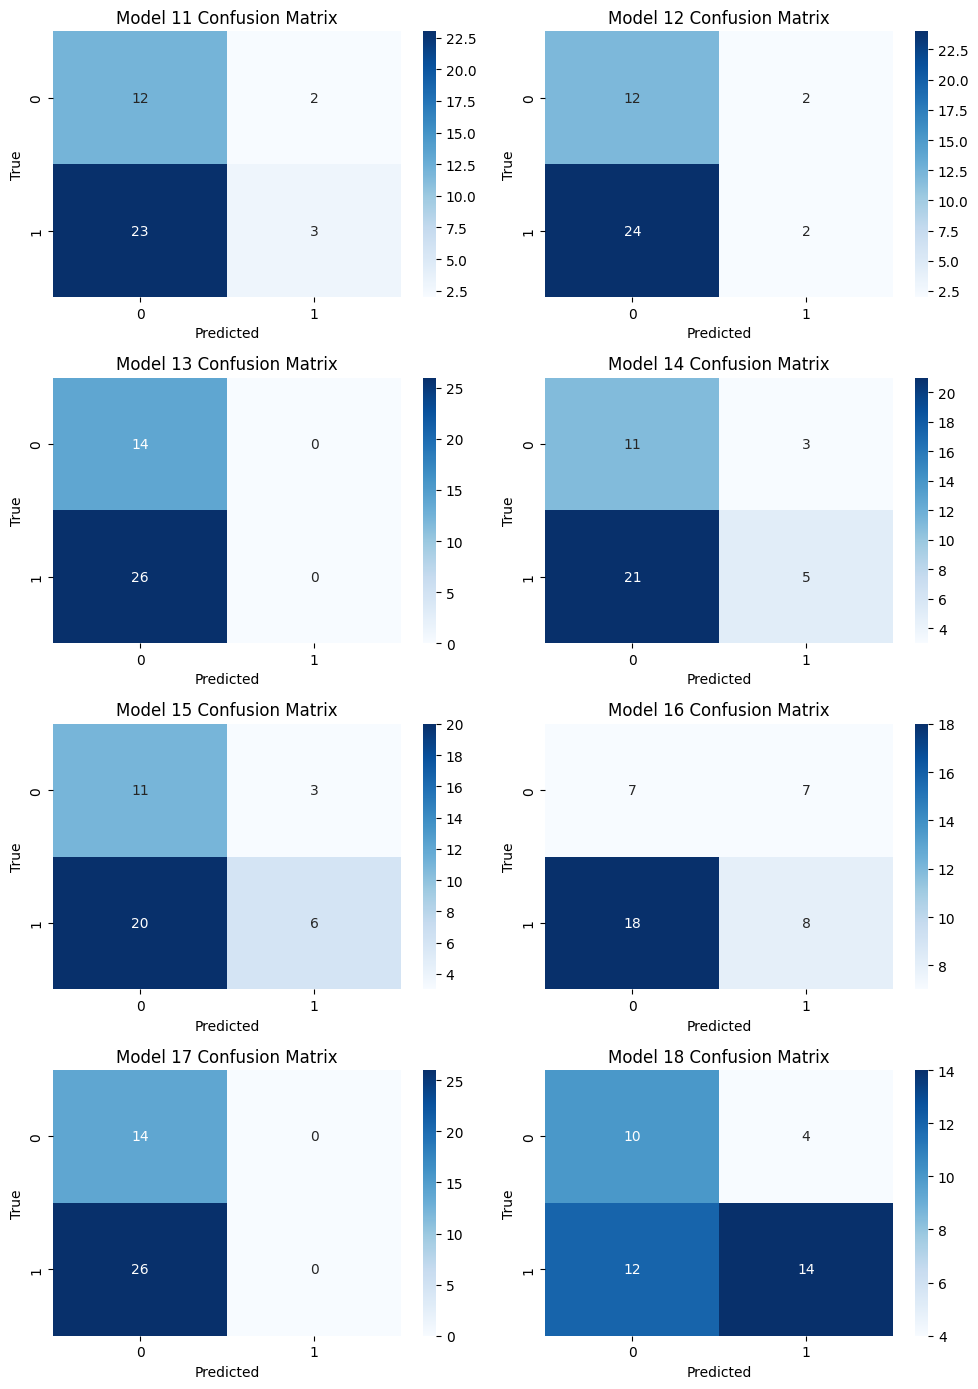

In [20]:
# Sentiment Models
sentiment_labels = wrangled_data.loc[:,'Sentiment']

# Preprocess - tf_idf
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, sentiment_labels, test_size=0.2, random_state=42)

# Logistic Regression
model_three = LogisticRegression(max_iter=1000)
model_three.fit(X_train, y_train)
model_three_predictions = model_three.predict(X_test)

# Naive Bayes
model_four = MultinomialNB()
model_four.fit(X_train, y_train)
model_four_predictions = model_four.predict(X_test)

# Support Vector Machine
model_five = SVC()
model_five.fit(X_train, y_train)
model_five_predictions = model_five.predict(X_test)

# Random Forest
model_six = RandomForestClassifier(n_estimators=100)
model_six.fit(X_train, y_train)
model_six_predictions = model_six.predict(X_test)

# Preprocess - doc2vec
X_train, X_test, y_train, y_test = train_test_split(list(wrangled_data['doc2vec_vectors']), sentiment_labels, test_size=0.2, random_state=42)

# Logistic Regression
model_seven = LogisticRegression(max_iter=1000)
model_seven.fit(X_train, y_train)
model_seven_predictions = model_seven.predict(X_test)

# Gaussian Naive Bayes
model_eight = GaussianNB()
model_eight.fit(X_train, y_train)
model_eight_predictions = model_eight.predict(X_test)

# Support Vector Machine
model_nine = SVC()
model_nine.fit(X_train, y_train)
model_nine_predictions = model_nine.predict(X_test)

# Random Forest
model_ten = RandomForestClassifier(n_estimators=100)
model_ten.fit(X_train, y_train)
model_ten_predictions = model_ten.predict(X_test)

sentiment_results = evaluate_models(y_test,model_three_predictions,model_four_predictions,model_five_predictions,model_six_predictions,model_seven_predictions,model_eight_predictions,model_nine_predictions,model_ten_predictions)
sentiment_results['Model'] = ['Three','Four','Five','Six','Seven','Eight','Nine','Ten']
sentiment_results['Type'] = ['Logistic Regression','Naive Bayes','Suppoer Vector Machine','Random Forest','Logistic Regression','Gaussian Naive Bayes','Support Vector Machine','Random Forest']
sentiment_results['Vectorization'] = ['td-idf'] * 4 + ['Doc2Vec'] * 4
display(sentiment_results.iloc[:,[-3,-2,-1,0,1,2,3]])

plot_confusion_matrices(y_test,model_three_predictions,model_four_predictions,model_five_predictions,model_six_predictions,model_seven_predictions,model_eight_predictions,model_nine_predictions,model_ten_predictions)

#### Part 3 - Multiclassification by Genre

,Model,Type,Vectorization,Accuracy,Precision,Recall,F1 Score
0,Eleven,Logistic Regression,td-idf,1.000,1.0000,1.000,1.0000
1,Twelve,Naive Bayes,td-idf,0.950,0.9625,0.950,0.9518
2,Thirteen,Suppoer Vector Machine,td-idf,1.000,1.0000,1.000,1.0000
3,Fourteen,Random Forest,td-idf,0.900,0.9210,0.900,0.9042
4,Fifteen,Logistic Regression,Doc2Vec,0.650,0.7145,0.650,0.6490
5,Seventeen,Gaussian Naive Bayes,Doc2Vec,0.375,0.3953,0.375,0.3665
6,Eighteen,Support Vector Machine,Doc2Vec,0.200,0.2737,0.200,0.1242
7,Nineteen,Random Forest,Doc2Vec,0.600,0.7107,0.600,0.6260


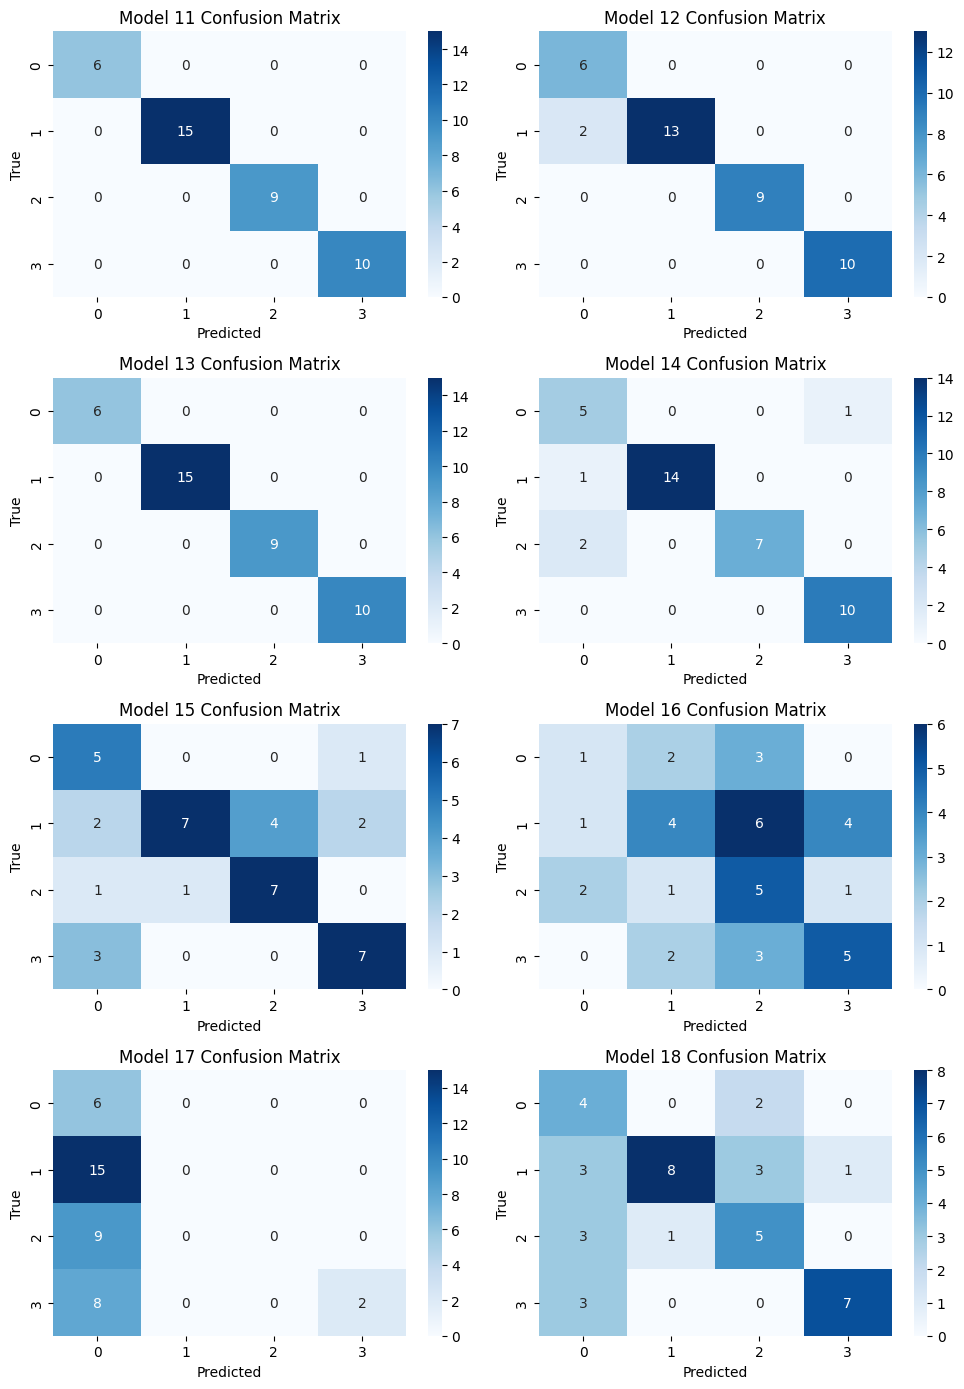

In [21]:
# Sentiment Models
sentiment_labels = wrangled_data.loc[:,'Genre']

# Preprocess - tf_idf
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, sentiment_labels, test_size=0.2, random_state=42)

# Logistic Regression
model_three = LogisticRegression(max_iter=1000)
model_three.fit(X_train, y_train)
model_three_predictions = model_three.predict(X_test)

# Naive Bayes
model_four = MultinomialNB()
model_four.fit(X_train, y_train)
model_four_predictions = model_four.predict(X_test)

# Support Vector Machine
model_five = SVC()
model_five.fit(X_train, y_train)
model_five_predictions = model_five.predict(X_test)

# Random Forest
model_six = RandomForestClassifier(n_estimators=100)
model_six.fit(X_train, y_train)
model_six_predictions = model_six.predict(X_test)

# Preprocess - doc2vec
X_train, X_test, y_train, y_test = train_test_split(list(wrangled_data['doc2vec_vectors']), sentiment_labels, test_size=0.2, random_state=42)

# Logistic Regression
model_seven = LogisticRegression(max_iter=1000)
model_seven.fit(X_train, y_train)
model_seven_predictions = model_seven.predict(X_test)

# Gaussian Naive Bayes
model_eight = GaussianNB()
model_eight.fit(X_train, y_train)
model_eight_predictions = model_eight.predict(X_test)

# Support Vector Machine
model_nine = SVC()
model_nine.fit(X_train, y_train)
model_nine_predictions = model_nine.predict(X_test)

# Random Forest
model_ten = RandomForestClassifier(n_estimators=100)
model_ten.fit(X_train, y_train)
model_ten_predictions = model_ten.predict(X_test)

sentiment_results = evaluate_models(y_test,model_three_predictions,model_four_predictions,model_five_predictions,model_six_predictions,model_seven_predictions,model_eight_predictions,model_nine_predictions,model_ten_predictions)
sentiment_results['Model'] = ['Eleven','Twelve','Thirteen','Fourteen','Fifteen','Seventeen','Eighteen','Nineteen']
sentiment_results['Type'] = ['Logistic Regression','Naive Bayes','Suppoer Vector Machine','Random Forest','Logistic Regression','Gaussian Naive Bayes','Support Vector Machine','Random Forest']
sentiment_results['Vectorization'] = ['td-idf'] * 4 + ['Doc2Vec'] * 4
display(sentiment_results.iloc[:,[-3,-2,-1,0,1,2,3]])

plot_confusion_matrices(y_test,model_three_predictions,model_four_predictions,model_five_predictions,model_six_predictions,model_seven_predictions,model_eight_predictions,model_nine_predictions,model_ten_predictions)

#### Part 4 - Topic Modeling

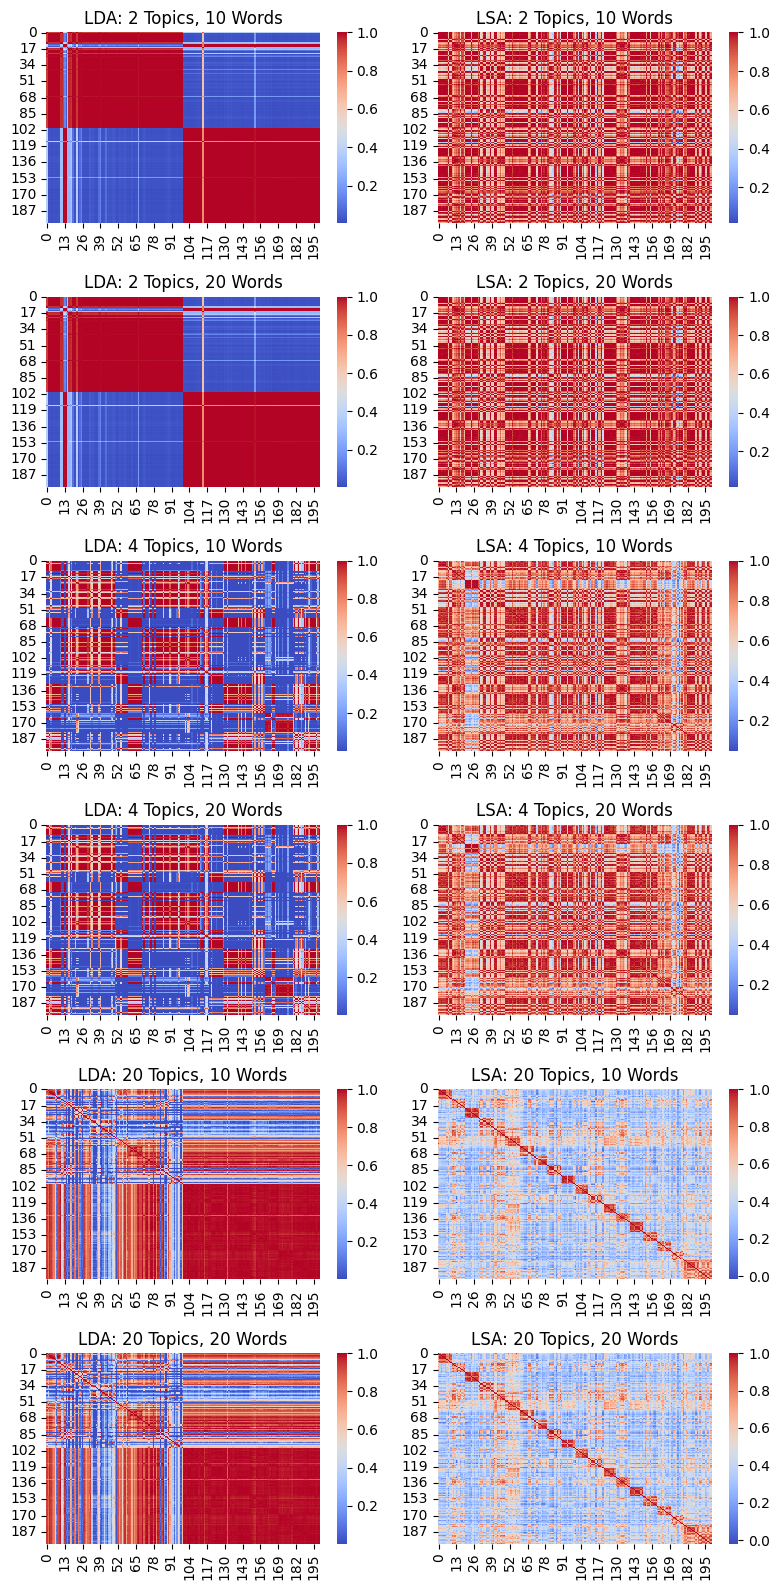

In [22]:
dictionary = corpora.Dictionary(wrangled_data['Text'])
corpus = [dictionary.doc2bow(text) for text in wrangled_data['Text']]

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(text) for text in wrangled_data['Text']])

fig, axs = plt.subplots(6, 2, figsize=(8, 16))

for index, (num_topics, word_size) in enumerate(itertools.product([2, 4, 20], [10, 20])):
    
    # LDA
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    lda_doc_topics = [lda_model.get_document_topics(bow, minimum_probability=0.0) 
                      for bow in corpus]
    lda_topic_matrix = np.array([[topic_prob for _, topic_prob in doc] 
                                for doc in lda_doc_topics])
    
    lda_cosine_similarities = cosine_similarity(lda_topic_matrix)
    sns.heatmap(lda_cosine_similarities, ax=axs[index][0], cmap='coolwarm')
    axs[index][0].set_title(f'LDA: {num_topics} Topics, {word_size} Words')
    
    # LSA
    lsi_model = gensim.models.LsiModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
    lsi_corpus = lsi_model[corpus]
    lsi_topic_matrix = gensim.matutils.corpus2dense(lsi_corpus, num_terms=num_topics).T
    lsi_cosine_similarities = cosine_similarity(lsi_topic_matrix)
    sns.heatmap(lsi_cosine_similarities, ax=axs[index][1], cmap='coolwarm')
    axs[index][1].set_title(f'LSA: {num_topics} Topics, {word_size} Words')

plt.tight_layout()
plt.show()
